In [14]:
from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle

from modules.variables import *
from modules.masks import mask_counts, mask_excess

from GPyUtils.map import MapProcessor, MapAnalyzer
from GPyUtils.general_utils import write_json, resampling

import json
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# Define the name of the dataset file
IDs = 'all_IDs'
e_min = 1
e_max = 200
bin = 20
binsz = 0.02
dataset_name = f"width_22x10/dataset_{IDs}_ene_{e_min}_{e_max}_bin_{bin}_binsz_{binsz}.fits.gz"
# Read the dataset
dataset = MapDataset.read(filename= path_to_datasets / dataset_name)
dataset = resampling(dataset, e_min, e_max, bin, factor=5)
# The maps are cubes, with an energy axis.
# Let's also make some images:
dataset_image = dataset.to_image()

In [16]:
mask_map = Map.read(path_to_maps / "exclusion_mask.fits")
mask_map = mask_map.downsample(factor=5)
mask_map.data = mask_map.data.astype(bool)

<WCSAxes: >

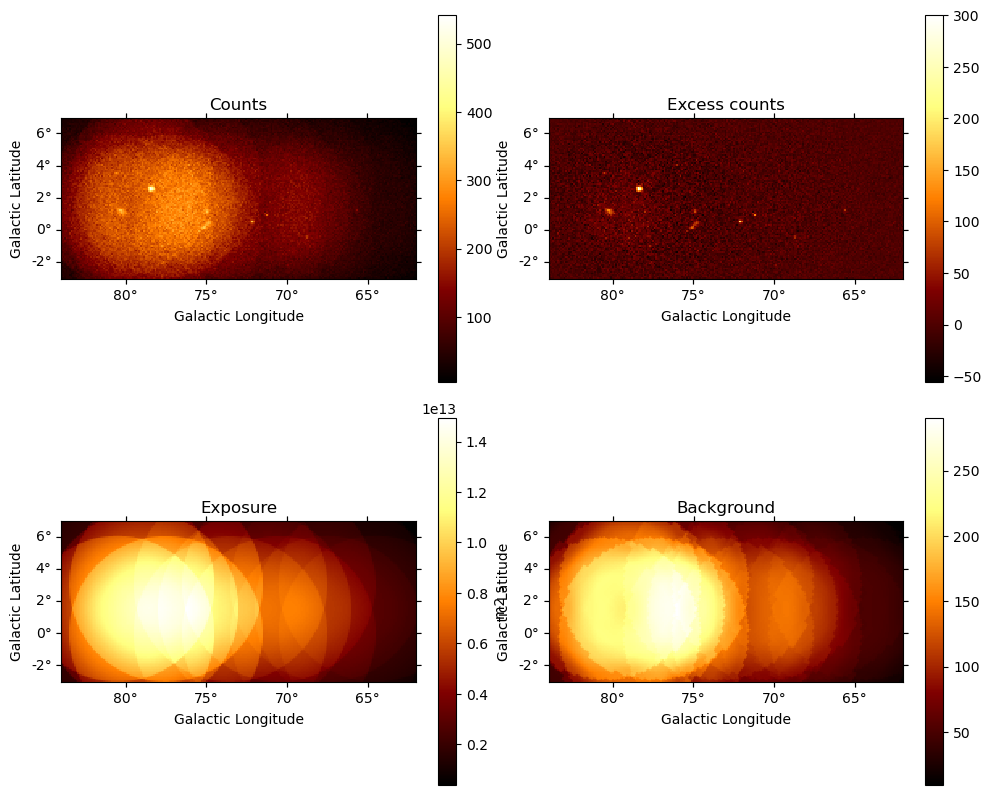

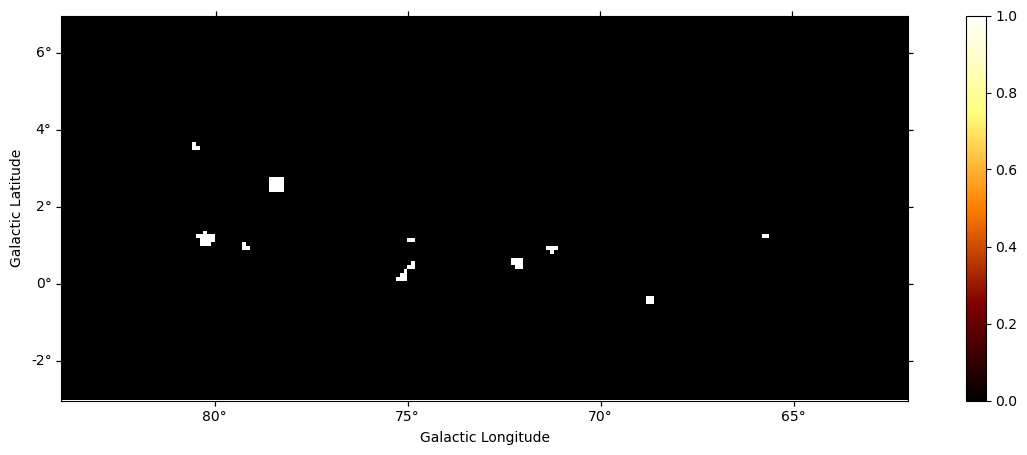

In [17]:
dataset.peek()
plt.figure(figsize=(15,5))
mask_map.plot(add_cbar=True)

### Show the counts/exposure map
The two maps have different geometries, so a little bit of manipulation is needed

In [18]:
counts = dataset_image.counts
excess = dataset_image.excess
exposure_image = dataset_image.exposure.sum_over_axes()

counts = mask_counts(counts, mask_map)
#excess = mask_excess(excess, mask_map)

map_processor = MapProcessor(counts)

new_map = map_processor.create_corrected_counts_map(exposure_image, normalize=True)

<WCSAxes: >

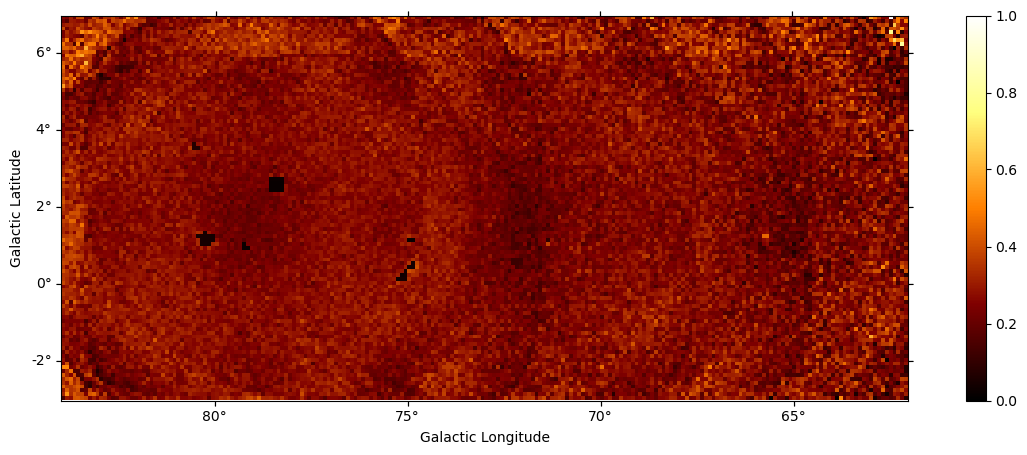

In [19]:
plt.figure(figsize=(15,5))
new_map.plot(add_cbar=True)

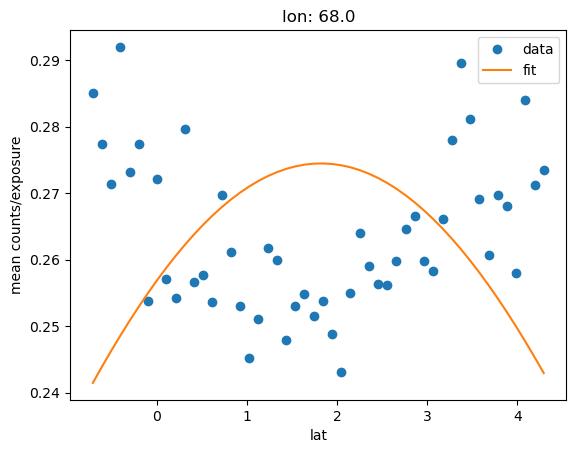

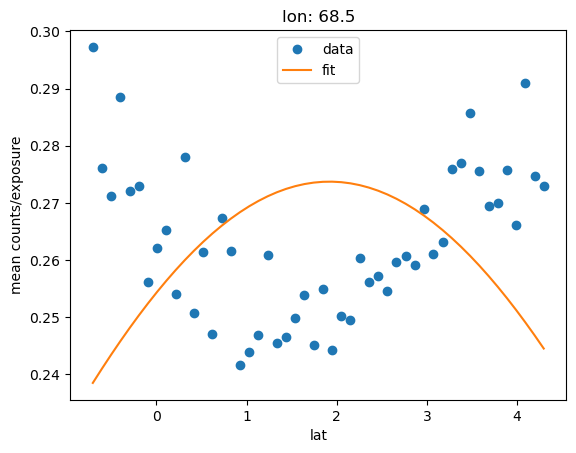

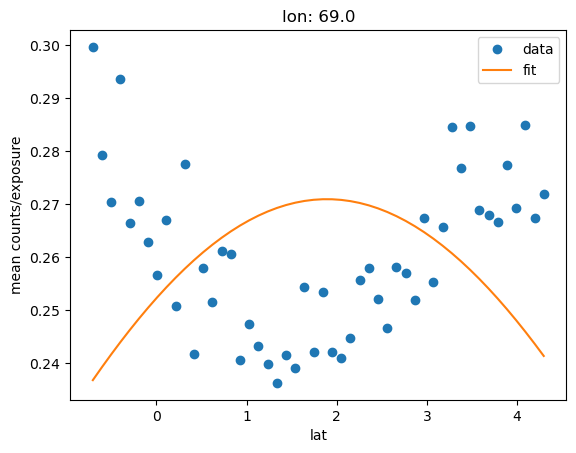

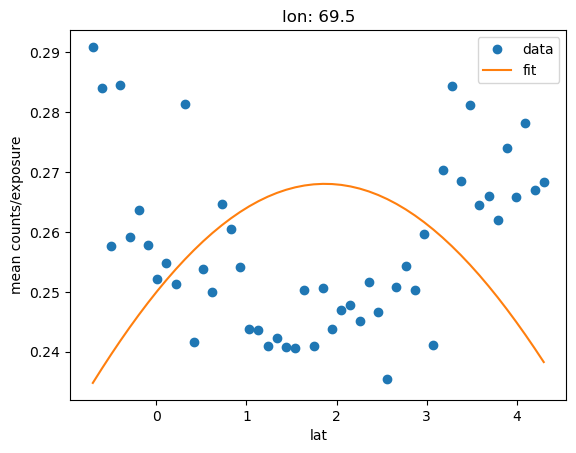

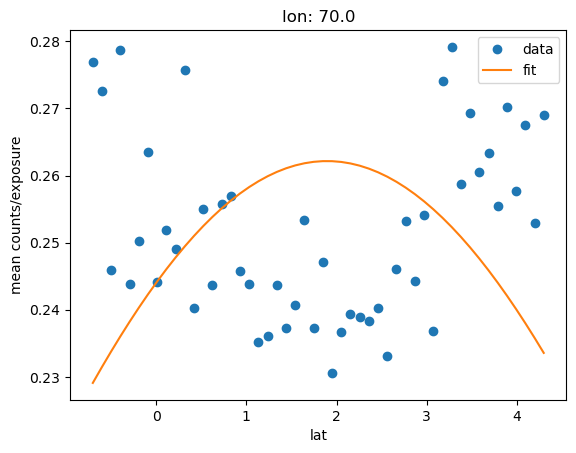

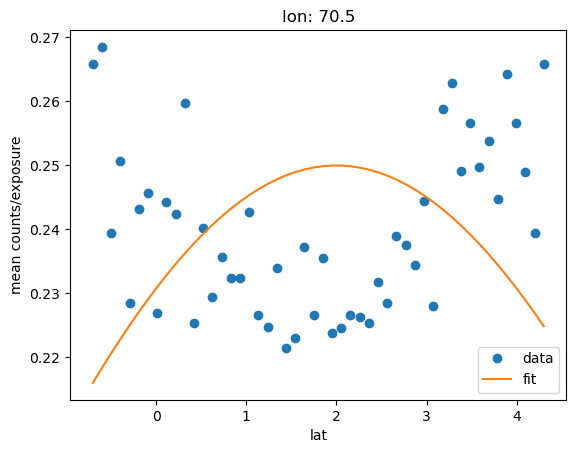

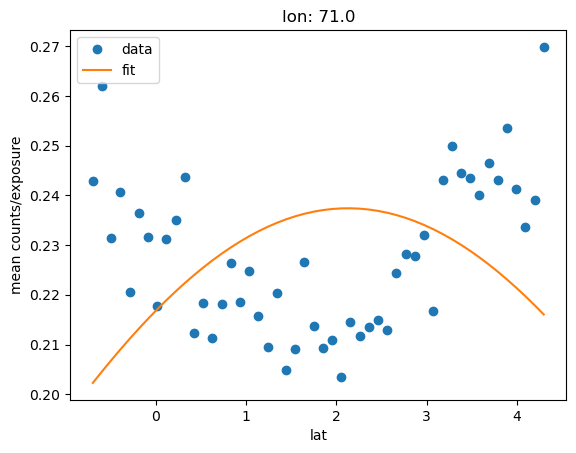

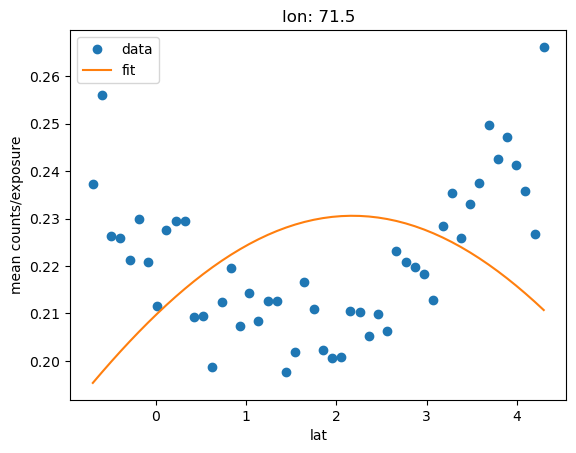

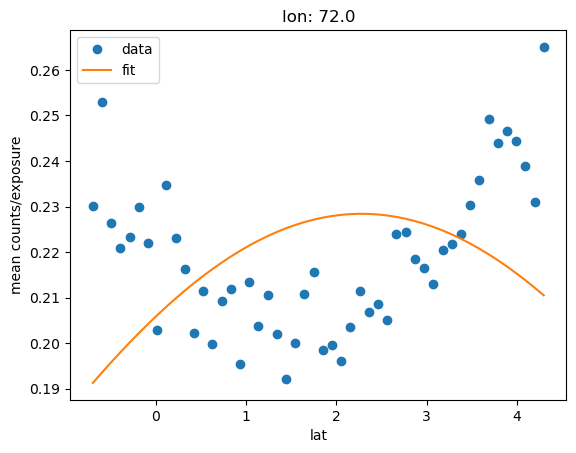

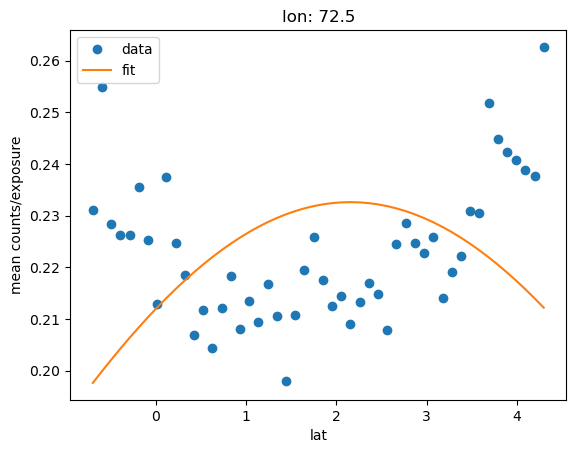

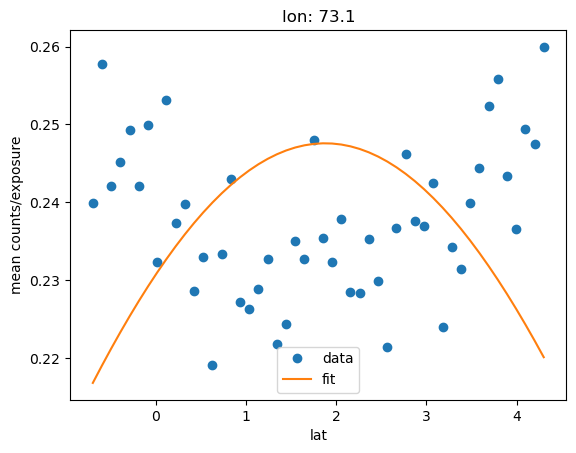

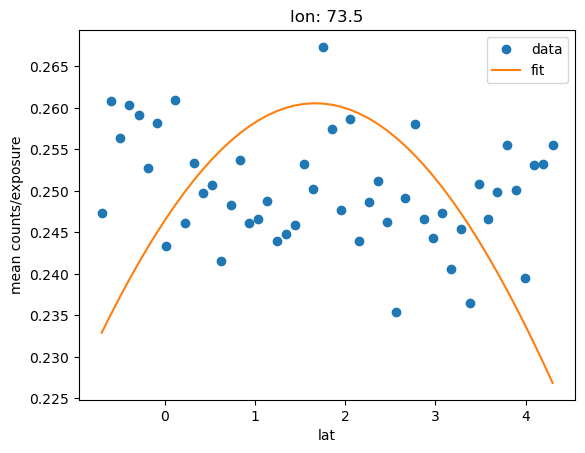

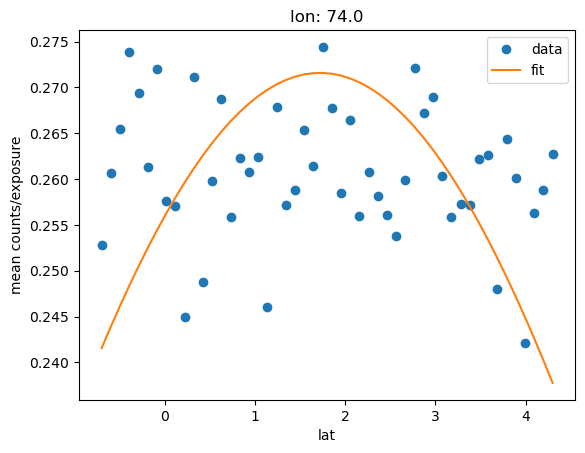

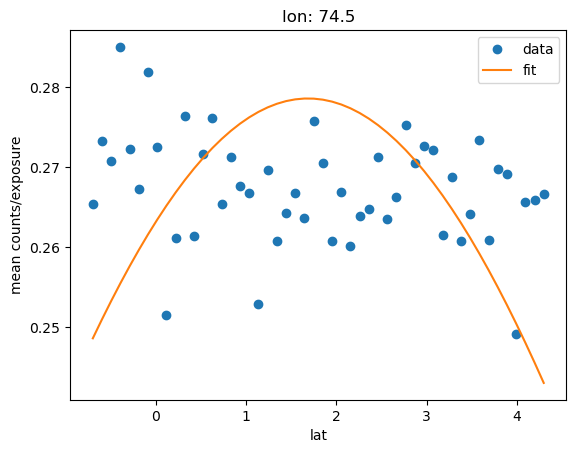

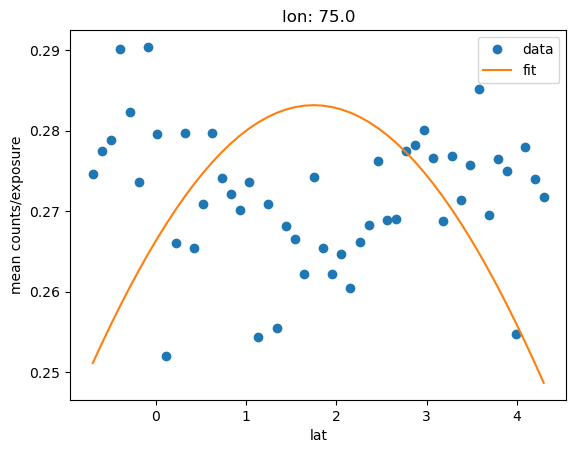

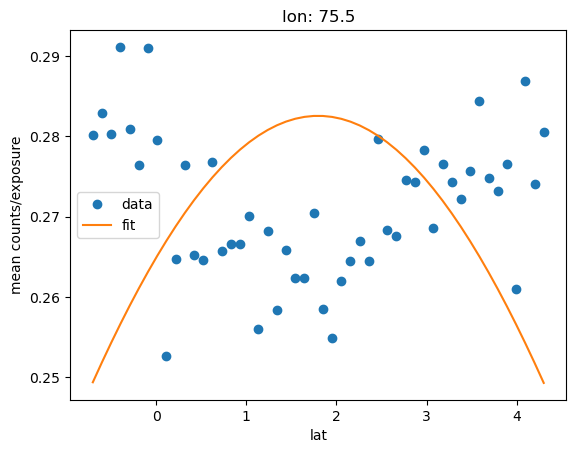

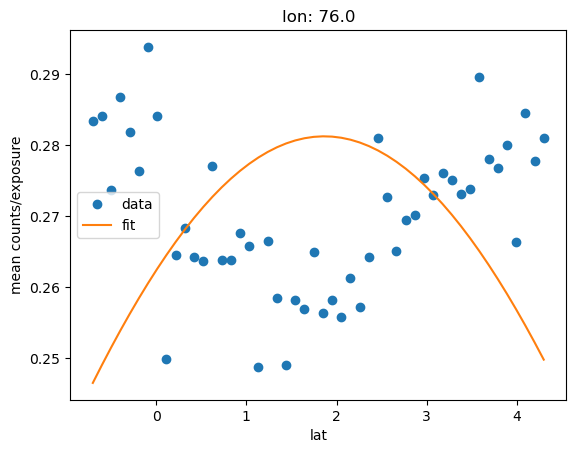

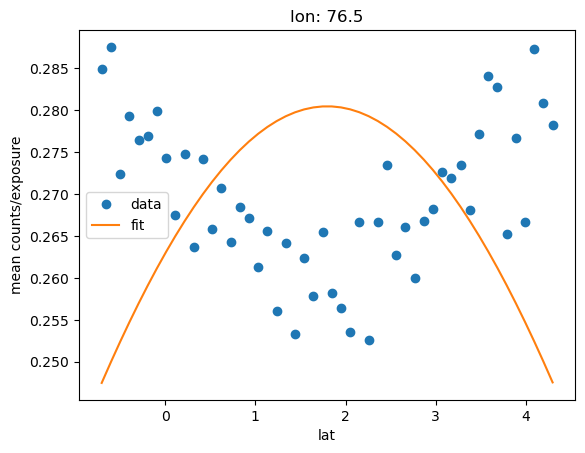

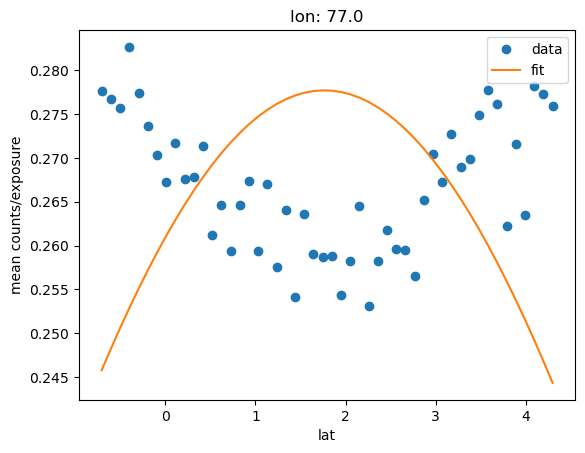

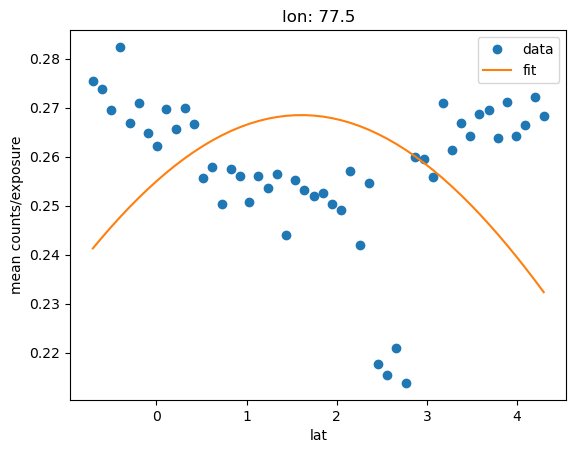

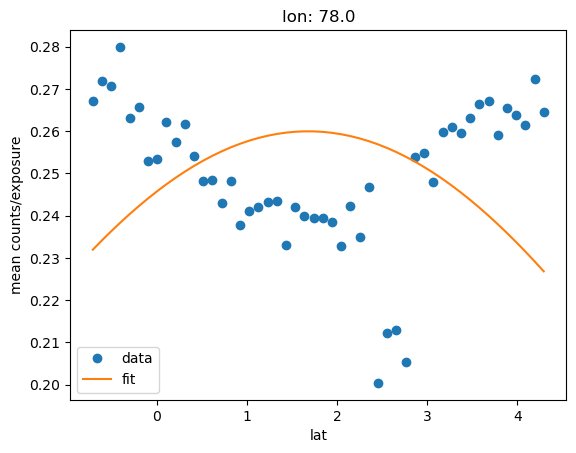

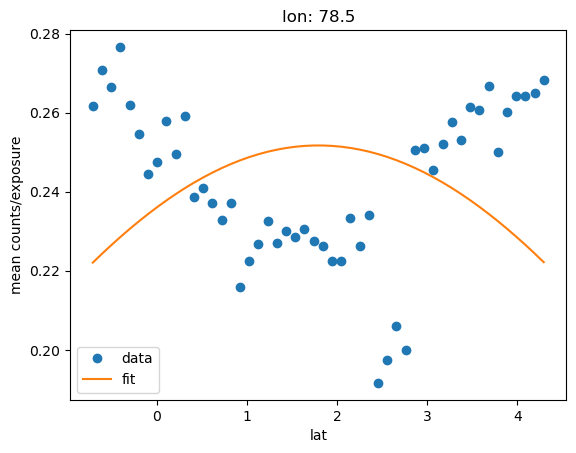

In [20]:
# Create JSON file
with open(path_to_json / "results_fit.json", "w") as outfile:
    json.dump({}, outfile)

for i in np.arange(68, 79, 0.5):
    pos_cutout = SkyCoord(i, 1.8, frame='galactic', unit='deg')
    section = new_map.cutout(pos_cutout, (Angle(2.5 * u.deg), Angle(5 * u.deg)))
    
    map_analyzer = MapAnalyzer(section)
    result = map_analyzer.gaussian_fit(plot_gauss=True, constant=False)
    
    results = {
        str(i): result,
    }
    write_json(results, path_to_json / "results_fit.json")

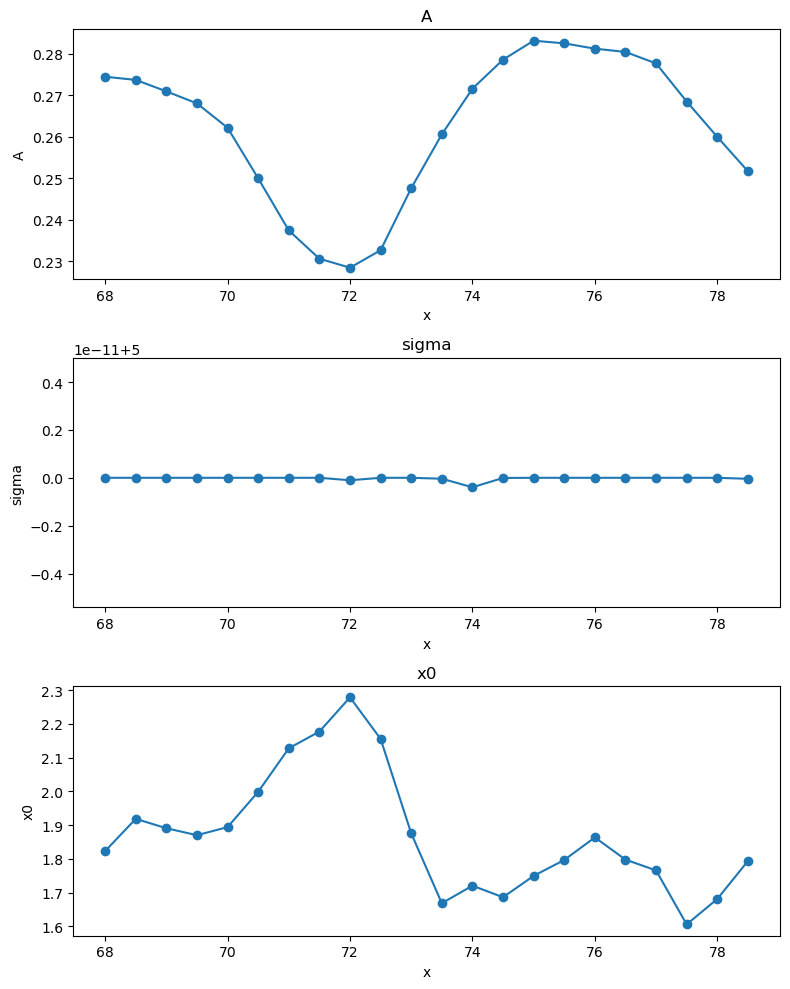

In [21]:
res_json = map_analyzer.read_json(path_to_json / "results_fit.json")
map_analyzer.plot_data(res_json)